In [2]:
import numpy as np
import cv2
import matplotlib.pyplot as plt
import os
import sys
from PIL import Image 


In [4]:
def load_image(filename):
  img = np.asarray(Image.open(filename))
  img = img.astype("float32")/255.0
  return img

def show_image(img):
  fig = plt.figure()
  fig.set_size_inches(8, 6) # You can adjust the size of the displayed figure
  plt.imshow(img)

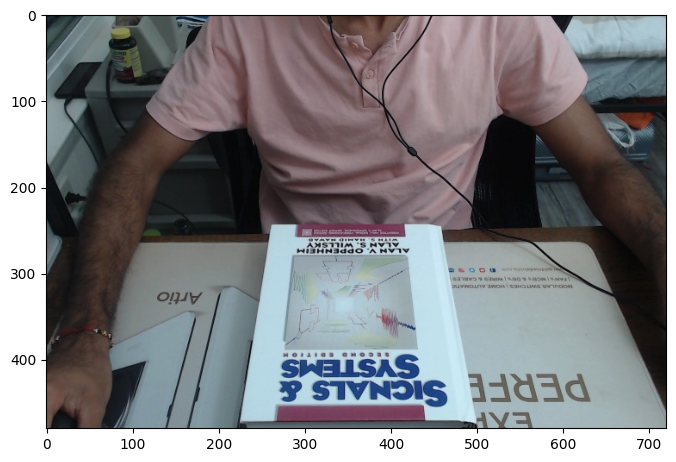

In [5]:
image = load_image("test_images/test1.jpg")
show_image(image)

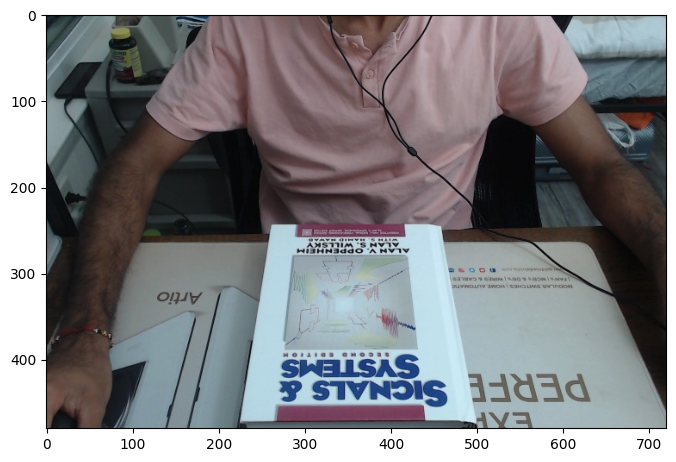

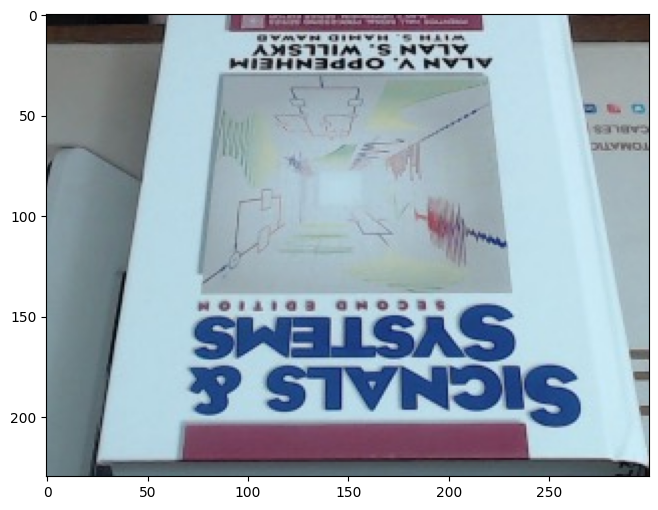

In [8]:
x1, y1 = 200, 250  # Top-left corner
x2, y2 = 500, 500  # Bottom-right corner

# Crop the region of interest from the image
roi = image[y1:y2, x1:x2]

# Display the original image and the selected region of interest
show_image(image)
show_image(roi)

In [10]:
def compute_homography(src, dst):
  '''Computes the homography from src to dst.
   Input:
    src: source points, shape (N, 2), where N >= 4
    dst: destination points, shape (N, 2)
   Output:
    H: homography from source points to destination points, shape (3, 3)'''

  #making matrix A from src and dst points

  a = np.zeros([2*len(src),9])
  for i in range(len(src)):
    a[2*i,:]=[src[i,0],src[i,1],1,0,0,0,-src[i,0]*dst[i,0],-src[i,1]*dst[i,0],-dst[i,0]]
    a[2*i+1,:]=[0,0,0,src[i,0],src[i,1],1,-src[i,0]*dst[i,1],-src[i,1]*dst[i,1],-dst[i,1]]
  # print("A: ",a)

  #finding out eigenvalues and eigenvectors of AtA

  c,d = np.linalg.eigh(np.dot(np.transpose(a),a))
  d=d[:,0]
  d=d/d[-1]
  # print(d)
  H = np.reshape(d,[3,3])
  # print("H: ",H)
  return H

##############################
# TO DO: Implement the apply_homography function

def apply_homography(src, H):
  '''Applies a homography H to the source points.
   Input:
      src: source points, shape (N, 2)
      H: homography from source points to destination points, shape (3, 3)
   Output:
     dst: destination points, shape (N, 2)
  '''

  dst= np.zeros([len(src),2])
  for i in range(len(src)):
    temp = np.dot(H,np.array([src[i,0],src[i,1],1]))
    dst[i]=[temp[0]/temp[2],temp[1]/temp[2]]
  # print("dst: ",dst)
  return dst

def warp_img(src_img, H, dst_img_size):
  '''Warping of a source image using a homography.
   Input:
      src_img: source image with shape (m, n, 3)
      H: homography, with shape (3, 3), from source image to destination image
      dst_img_size: height and width of destination image; shape (2,)
   Output:
      dst_img: destination image; height and width specified by dst_img_size parameter
  '''

  dst_img = np.zeros((dst_img_size[0],dst_img_size[1],3))
  m,n = dst_img_size[0],dst_img_size[1]
  p,q = src_img.shape[0],src_img.shape[1]

  # print(dst_img.shape)
  # print("Destination Size: ",m,n)
  # print("Source Size: ",p,q)
  # print(dst_img)
  # print(int(temp[0,0]),int(temp[0,1]))
  # print("H: ",H)
  H = np.mat(H)
  H_inv = np.linalg.inv(H)



  for i in range(m):
    for j in range(n):

      temp = np.dot(H_inv,np.array([i,j,1]))
      temp1 = temp[0,0]/temp[0,2]
      temp2 = temp[0,1]/temp[0,2]

      if 0<=int(temp1)<p and 0<=int(temp2)<q:
        dst_img[i,j]=src_img[int(temp1),int(temp2)]

  return dst_img

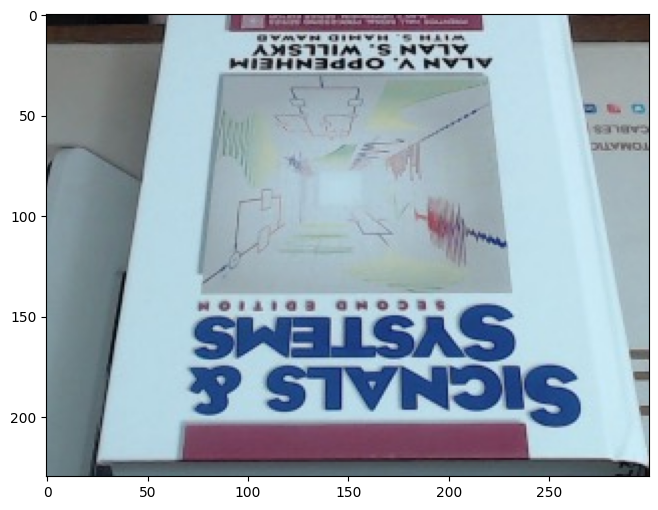

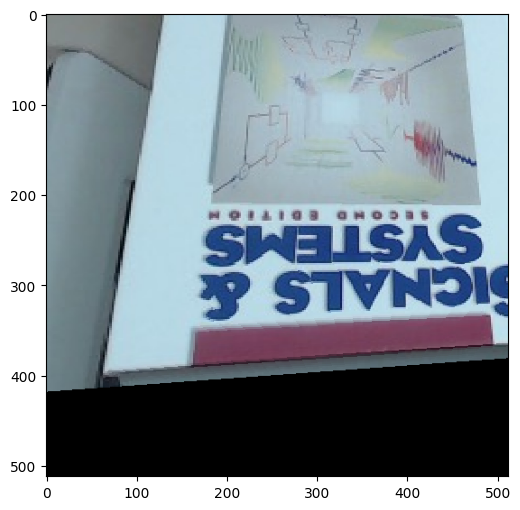

In [12]:
output_image = np.zeros([512,512,3])
src_pts = np.matrix('50, 0; 270, 0; 300, 250; 25, 250')
canvas_pts = np.matrix('0, 0; 511, 0; 511, 511; 0, 511')
H = compute_homography(src_pts, canvas_pts)
dst_img = warp_img(roi, H, [output_image.shape[0], output_image.shape[1]])
show_image(roi)
show_image(dst_img)


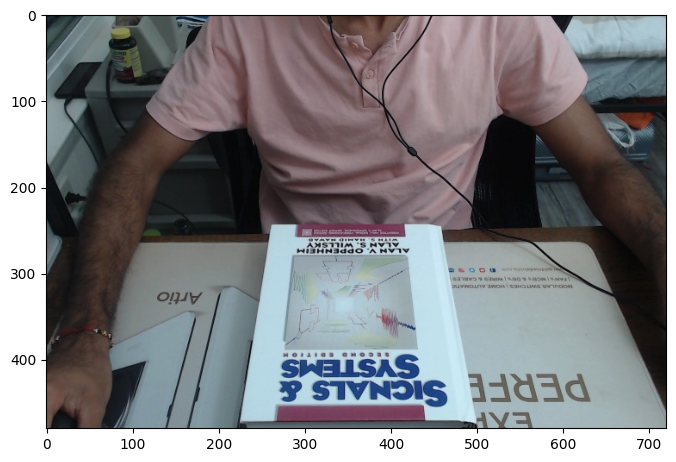

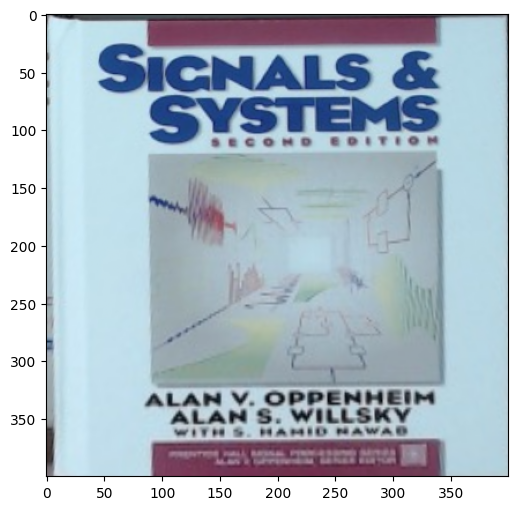

In [19]:
trapezoid_pts = np.array([[263, 245], [462, 246], [502, 476], [224, 474]], dtype='float32')
# trapezoid_pts = np.array([[245, 263], [246, 462], [476, 502], [474, 224]], dtype='float32')

# Define the coordinates of the four corners of the desired rectangle (in the same order)

rectangle_pts = np.array([[0, 0], [400, 0], [400, 400], [0, 400]], dtype='float32')

# Compute the perspective transformation matrix
perspective_matrix = cv2.getPerspectiveTransform(trapezoid_pts, rectangle_pts)

# Apply the perspective transformation to the image
transformed_image = cv2.warpPerspective(image, perspective_matrix, (400, 400))  # Adjust the size as needed
transformed_image = cv2.rotate(transformed_image,cv2.ROTATE_180)
show_image(image)
show_image(transformed_image)